# Lakh MIDI Dataset Tutorial

This IPython notebook demonstrates how to use the data in the [Lakh MIDI Dataset](http://colinraffel.com/projects/lmd/).  It shows how the dataset is organized and gives examples of how to use annotations extracted from `LMD-aligned` (the collection of MIDI files which have been matched and aligned to entries in the Million Song Dataset).  We will use [`pretty_midi`](https://github.com/craffel/pretty-midi) for parsing the MIDI files, [`mir_eval`](https://github.com/craffel/mir_eval) for sonification and visualization, and [`librosa`](https://github.com/librosa/librosa) for audio analysis.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pretty_midi
import librosa
import mir_eval
import mir_eval.display
# import tables
import IPython.display
import os
import json
# print(os.getcwd())
# os.chdir('d:\\DASAN_Summer')
# print(os.getcwd())

# os.chdir('d:\\DASAN_Summer\\project\\midi')
os.environ['PATH'] += os.pathsep + 'd:\\DASAN_Summer\\fluidsynth-2.3.3-win10-x64\\bin'
import fluidsynth
# Local path constants
DATA_PATH = './data'
RESULTS_PATH = '../Dataset/'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join('match.json')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(h5):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

ImportError: Couldn't find the FluidSynth library.

## Data layout

The file [`match_scores.json`](http://colinraffel.com/projects/lmd/match_scores.json) is a good place to start.  It holds a dictionary of dictionaries.  The first dictionary is keyed by Million Song Dataset IDs.  Each entry in this dictionary is a dictionary which maps MD5 checksums of files in the Lakh MIDI Dataset to scores in the range `[0.5, 1.0]` which represent the confidence that a given MIDI file matches a given Million Song Dataset entry.  This range of confidence scores is due to the fact that below `0.5` it's likely that the match is invalid.  Here's an example:

In [2]:
with open(SCORE_FILE) as f:
    scores = json.load(f)
# Grab a Million Song Dataset ID from the scores dictionary
print(len(list(scores.keys())))
# input('Press Enter to continue...')
msd_id = list(scores.keys())[1]
print ('Million Song Dataset ID {} has {} MIDI file matches:'.format(
    msd_id, len(scores[msd_id])))
for midi_md5, score in scores[msd_id].items():
    print ('  {} with confidence score {}'.format(midi_md5, score))

31034
Million Song Dataset ID TRWMHMP128EF34293F has 2 MIDI file matches:
  c3da6699f64da3db8e523cbbaa80f384 with confidence score 0.7321245522741104
  d8392424ea57a0fe6f65447680924d37 with confidence score 0.7476196649194942


This Million Song Dataset entry has 5 MIDI files matched to it, with scores between ~.69 and .78.  There are multiple MIDI files matched to this one Million Song Dataset entry because the Lakh MIDI Dataset has multiple _different_ MIDI transcriptions of this single piece of music.

MIDI files which have been matched to the Million Song Dataset are distributed in the Lakh MIDI Dataset in two formats:  `LMD-matched` provides them in their raw form as they were scraped from the internet; and `LMD-aligned` contains modified versions which have been aligned to the 7digital preview MP3s which accompany the Million Song Dataset.  The directory structure of both of these packages follows the Million Song Dataset.  For example, the MIDI files we just inspected above appear in
```
N/C/Z/TRNCZVX128F92F9018/a92af10c0349706ba12552011f7f77a8.mid
N/C/Z/TRNCZVX128F92F9018/335a5edca8882f4d2725683d7c530aac.mid
N/C/Z/TRNCZVX128F92F9018/8e2bbe4485b113ba48762b1e3032795a.mid
N/C/Z/TRNCZVX128F92F9018/df21ff6afbeab449e4d415167c54decf.mid
N/C/Z/TRNCZVX128F92F9018/22a0142b14b393b1515062d8a006814e.mid
```

## Utilizing aligned MIDI files

MIDI files provide a wide variety of useful information.  Moreover, when they are matched and aligned to audio recordings, they can be used to derive annotations about the recording.  Below is a demonstration of how to extract this information from the files in `LMD-aligned`.  We'll start by grabbing a MIDI file which has all of the useful information we will demonstrate.

In [3]:
while True:
    # Grab an MSD ID and its dictionary of matches
    msd_id, matches = scores.popitem()
    # Grab a MIDI from the matches
    midi_md5, score = matches.popitem()
    # Construct the path to the aligned MIDI
    aligned_midi_path = get_midi_path(msd_id, midi_md5, 'matched')
    # Load/parse the MIDI file with pretty_midi
    pm = pretty_midi.PrettyMIDI(aligned_midi_path)
    # Look for a MIDI file which has lyric and key signature change events
    if len(pm.lyrics) > 5 and len(pm.key_signature_changes) > 0:
        break

d:\anaconda\envs\midi\Lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [4]:
# MIDI files in LMD-aligned are aligned to 7digital preview clips from the MSD
# Let's listen to this aligned MIDI along with its preview clip
# Load in the audio data
# audio, fs = librosa.load(msd_id_to_mp3(msd_id))
# Synthesize the audio using fluidsynth
fs = 10000
midi_audio = pm.fluidsynth(fs)
# Play audio in one channel, synthesized MIDI in the other
IPython.display.Audio([midi_audio], rate=fs)

ImportError: fluidsynth() was called but pyfluidsynth is not installed.

### Metadata from the Million Song Dataset

We can use information from the h5 file for the Million Song Dataset entry to determine metadata about this MIDI file match.  The Million Song Dataset also has additional useful information, like terms which describe the artist.

In [9]:
with tables.open_file(msd_id_to_h5(msd_id)) as h5:
    print 'ID: {}'.format(msd_id)
    print '"{}" by {} on "{}"'.format(
        h5.root.metadata.songs.cols.title[0],
        h5.root.metadata.songs.cols.artist_name[0],
        h5.root.metadata.songs.cols.release[0])
    print 'Top 5 artist terms:', ', '.join(list(h5.root.metadata.artist_terms)[:5])

ID: TRALLSG128F425A685
"White Flag" by Dido on "Life For Rent"
Top 5 artist terms: singer-songwriter, rock, pop, alternative, indie


### Transcription

MIDI files are at their core a way of storing a score of a piece of music, so the MIDI files in the Lakh MIDI dataset can be used to obtain a transcription of the audio files they are matched and aligned to.  `pretty_midi`'s `get_piano_roll()` method provides a convenient way of getting a "piano roll representation" of the transcription.

In [10]:
# Retrieve piano roll of the MIDI file
piano_roll = pm.get_piano_roll()
# Use 7 octaves starting from C1
piano_roll = piano_roll[12:96]
# Retrieve the audio corresponding to this MSD entry
audio, fs = librosa.load(msd_id_to_mp3(msd_id))
# Compute constant-Q spectrogram
cqt = librosa.logamplitude(librosa.cqt(audio))
# Normalize for visualization
cqt = librosa.util.normalize(cqt)

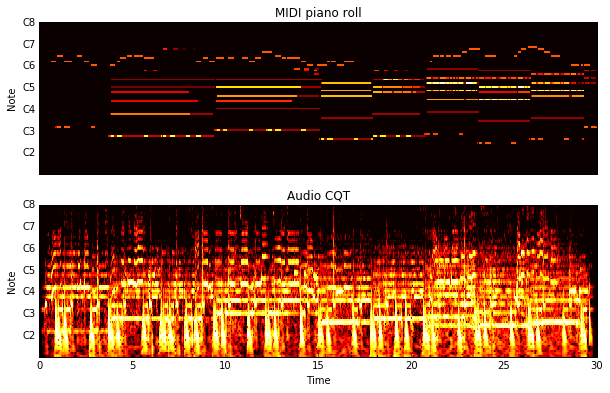

In [11]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
librosa.display.specshow(piano_roll, y_axis='cqt_note', cmap=plt.cm.hot)
plt.title('MIDI piano roll')
plt.subplot(212)
librosa.display.specshow(cqt, y_axis='cqt_note', x_axis='time',
                         cmap=plt.cm.hot, vmin=np.percentile(cqt, 25))
plt.title('Audio CQT');

In MIDI files, different instruments are transcribed on different tracks or channels, which allows them to be separated easily.  You can therefore easily get per-instrument piano rolls with `pretty_midi`.  This enables the potential of creating annotations for melody extraction and score-informed source separation.  Note that while methods exist for giving instruments arbitrary text names, in practice are limited to the instruments in the General MIDI specification.

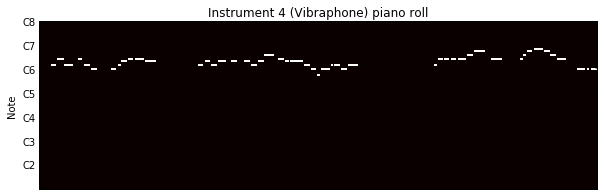

In [12]:
# Retrieve piano roll of one of the instruments
piano_roll = pm.instruments[4].get_piano_roll()
piano_roll = piano_roll[12:96]
plt.figure(figsize=(10, 3))
librosa.display.specshow(piano_roll, y_axis='cqt_note', cmap=plt.cm.hot)
# Get the text name of this instrument's program number
program_name = pretty_midi.program_to_instrument_name(pm.instruments[4].program)
plt.title('Instrument 4 ({}) piano roll'.format(program_name));

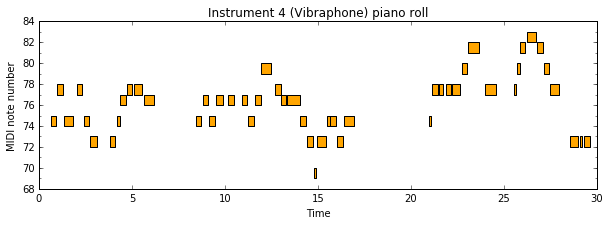

In [13]:
# pretty_midi also provides direct access to the pitch and start/end time of each note
intervals = np.array([[note.start, note.end] for note in pm.instruments[4].notes])
notes = np.array([note.pitch for note in pm.instruments[4].notes])
plt.figure(figsize=(10, 3))
mir_eval.display.piano_roll(intervals, midi=notes, facecolor='orange')
plt.title('Instrument 4 ({}) piano roll'.format(program_name))
plt.xlabel('Time')
plt.ylabel('MIDI note number');

### Meter

Because MIDI files are scores, they contain full meter information (e.g. time signatures, beats, and downbeats).  Since the MIDI files in `LMD-aligned` are aligned to corresponding 7digital preview clips in the Million Song Dataset, we can extract beat and downbeat annotations for the 7digital preview clip from the MIDI file directly.

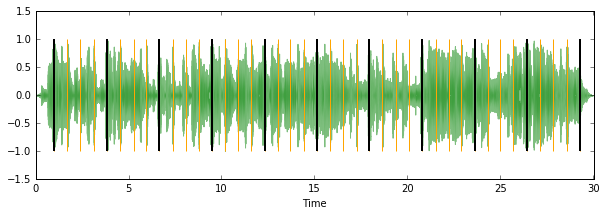

In [14]:
# Retrieve the beats and downbeats from pretty_midi
# Note that the beat phase will be wrong until the first time signature change after 0s
# So, let's start beat tracking from that point
first_ts_after_0 = [ts.time for ts in pm.time_signature_changes if ts.time > 0.][0]
# Get beats from pretty_midi, supplying a start time
beats = pm.get_beats(start_time=first_ts_after_0)
# .. downbeats, too
downbeats = pm.get_downbeats(start_time=first_ts_after_0)
# Display meter on top of waveform
plt.figure(figsize=(10, 3))
librosa.display.waveplot(audio, color='green', alpha=.5)
mir_eval.display.events(beats, base=-1, height=2, color='orange')
mir_eval.display.events(downbeats, base=-1, height=2, color='black', lw=2);

In [15]:
# Synthesize clicks at these downbeat times
beat_clicks = librosa.clicks(beats, length=audio.shape[0])
downbeat_clicks = librosa.clicks(downbeats, click_freq=2000, length=audio.shape[0])
IPython.display.Audio([audio, beat_clicks + downbeat_clicks], rate=fs)

### Key changes

MIDI files can contain key signature annotations.  They are, however, a completely optional meta-event, so many MIDI files don't have one.  Because key changes are rare in Western popular music, most MIDI files which do have key signature change annotations only have one.

In [19]:
# Print out all key changes in the MIDI file
for key_change in pm.key_signature_changes:
    print 'Key {} starting at time {:.2f}'.format(
        pretty_midi.key_number_to_key_name(key_change.key_number), key_change.time)

Key F Major starting at time 0.00


### Lyrics

MIDI files can also optionally have lyrics events, which are essentially timestamped text.  Lyrics are often transcribed at the syllable level, but also occasionally at the character or word level.  As with meter information, because the MIDI files in `LMD-aligned` are matched and aligned to 7digital preview MP3s, we can use the MIDI files to obtain timestamped lyrics transcriptions for these recordings.

In [20]:
# Get the boundaries of each line in the lyrics
lines = [0] + [n for n, lyric in enumerate(pm.lyrics) if '\r' in lyric.text]
for start, end in zip(lines[:-1], lines[1:]):
    # Print the times of each lyric in the line, delimited by |
    print '|'.join('{:>8.3f}'.format(lyric.time)
                   for lyric in pm.lyrics[start:end]
                   if lyric.text != '\r')
    # Print the text of each lyric in the line, delimited by |
    print '|'.join('{:>8}'.format(lyric.text)
                   for lyric in pm.lyrics[start:end]
                   if lyric.text != '\r')

   0.000
      IT
   0.629|   0.858|   1.011|   1.164|   1.316|   1.622|   1.776|   2.159|   2.541
     WEL|      L |      I'|      D |    STIL|      L |   HAVE |   FELT |      IT
   3.843|   4.239|   4.371|   4.636|   4.834|   5.033|   5.231
  WHERE'|      S |    THE |     SEN|     SE |     IN |   THAT?


   8.439|   8.797|   9.153|   9.511|  10.179|  10.892|  11.250|  11.607
      I |PROMISE |      I'|      M |    NOT | TRYING |     TO |    MAKE
  12.678|  13.036|  13.346|  14.061
   YOUR |   LIFE |     HAR|     DER
  14.417|  14.954|  15.489|  15.668|  16.025|  16.383
     OR | RETURN |     TO |  WHERE |     WE |    WERE


  20.979|  21.238|  21.412|  21.586|  21.845|  22.018|  22.279|  22.666|  23.100|  23.533
     WEL|      L |      I |     WIL|      L |     GO |   DOWN |   WITH |   THIS |    SHIP
  25.528|  25.809|  25.948|  26.230|  26.369|  26.650|  26.860|  27.281
    AND |      I |    WON'|      T |    PUT |     MY |  HANDS |      UP
  28.564|  29.100|  29.278|  29.636
    AN